In [1]:
using PyPlot,JLD2,CALCEPH
rc("font",family="serif")
include("CGS.jl")

Main.CGS

Using $\sqrt{e} \cos{\omega}$ and $\sqrt{e} \sin{\omega}$ as priors. 

Changed respecive lines in compute_ttv.jl, MCMC.jl and fit_mysterybody.jl 

In [187]:
calc_deg(value) = value * 180/pi
calc_rad(value) = value * pi/180
function extract_data(filename)
	f = jldopen(String(filename), "r")
	return f["pbest_global"]
end
function evec(ecc,om)
    omega = calc_rad(om)
    ecosw = ecc*cos(omega)
    esinw = ecc*sin(omega)
    return ecosw,esinw
end

evec (generic function with 1 method)

In [194]:
mu_1,P_1,t01,e1cosw1,e1sinw1,
mu_2,P_2,t02,e2cosw2,e2sinw2,
mu_3,P_3,t03,e3cosw3,e3sinw3,
tmaxsinphi0,tmaxcosphi0,deltaphi = extract_data("OUTPUTS/moon_fittry2params.jld2")

18-element Array{Float64,1}:
    2.551224594316028e-6 
  224.7007714102686      
    2.4335037688276754e6 
    0.003420681697110603 
   -0.0002182122565361728
    3.036634787270893e-6 
  365.2564657278818      
    2.4336244072983414e6 
    0.015226075676882358 
    0.0024219051230228925
    0.000977596784072095 
 4304.838315211312       
    2.4434227857896723e6 
    0.030420376403921114 
   -0.035077907806294516 
    6.300340624228565e-5 
   -0.0016114256872145198
    2.311017557459077    

In [195]:
@load("NYR40/moon_try2mcmc.jld2")

8-element Array{Symbol,1}:
 :par_mcmc    
 :lprob_mcmc  
 :param       
 :nwalkers    
 :nsteps      
 :accept      
 :iburn       
 :indepsamples

In [171]:
include("decompose_ttvs.jl")
include("plot_ttvs.jl")
include("plot_likelihood.jl")
include("corner_plot.jl")

corner_planet (generic function with 3 methods)

In [193]:
evec(0.00677323,131.53298)

(-0.004490997226230397, 0.005070265135758768)

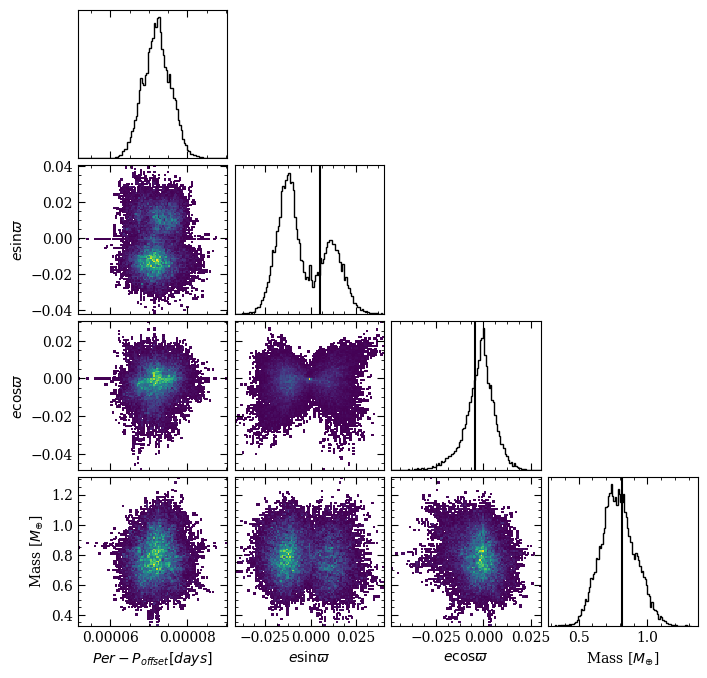

In [198]:
corner_planet(vec(par_mcmc[:,1:nsteps,1]).* CGS.MSUN/CGS.MEARTH,
    (vec(par_mcmc[:,1:nsteps,4]).*sqrt.(vec(par_mcmc[:,1:nsteps,4]).^2 .+ vec(par_mcmc[:,1:nsteps,5]).^2)),
    (vec(par_mcmc[:,1:nsteps,5]).*sqrt.(vec(par_mcmc[:,1:nsteps,4]).^2 .+ vec(par_mcmc[:,1:nsteps,5]).^2)),
    vec(par_mcmc[:,1:nsteps,2]),100,
0.815,-0.0044,0.0051,224.7007992,"venus")

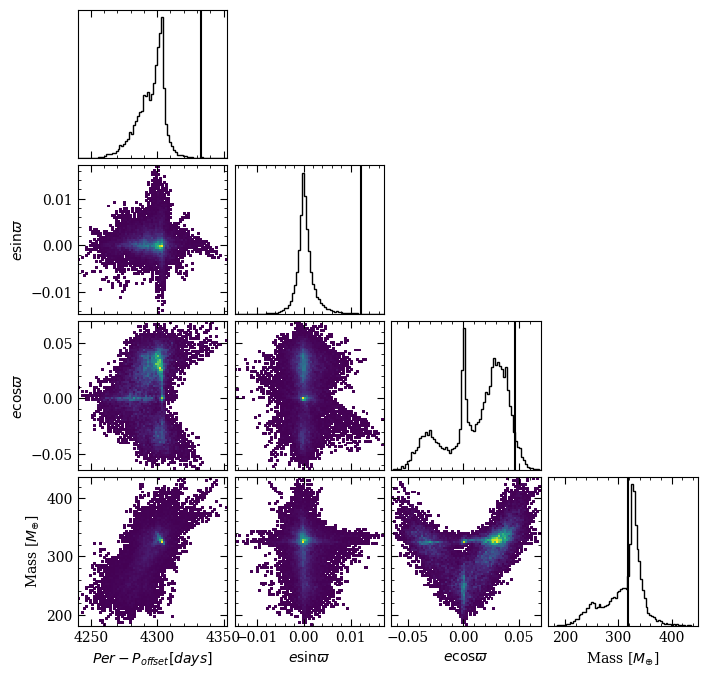

In [200]:
corner_planet(vec(par_mcmc[:,1:nsteps,11]).* CGS.MSUN/CGS.MEARTH,
     (vec(par_mcmc[:,1:nsteps,14]).*sqrt.(vec(par_mcmc[:,1:nsteps,14]).^2 .+ vec(par_mcmc[:,1:nsteps,15]).^2)),
   (vec(par_mcmc[:,1:nsteps,15]).*sqrt.(vec(par_mcmc[:,1:nsteps,14]).^2 .+ vec(par_mcmc[:,1:nsteps,15]).^2)),
    vec(par_mcmc[:,1:nsteps,12]),75,
318,0.0468,0.0123,4332.82012875,"jup")

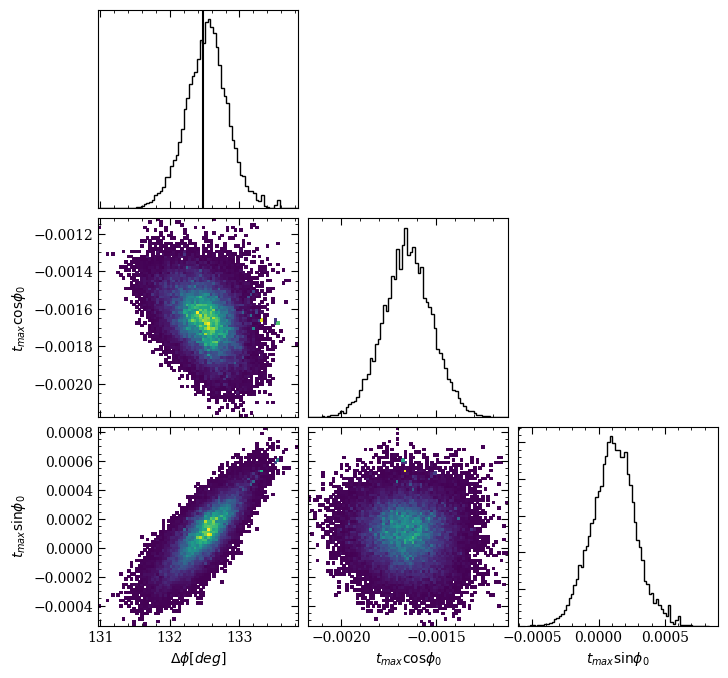

In [174]:
corner_moon(vec(par_mcmc[:,iburn:nsteps,16]),
    vec(par_mcmc[:,iburn:nsteps,17]),
    vec(par_mcmc[:,iburn:nsteps,18]).*57.2957795,75,
 0.00001,0.00001,2.3122.*57.2957795,"moon")

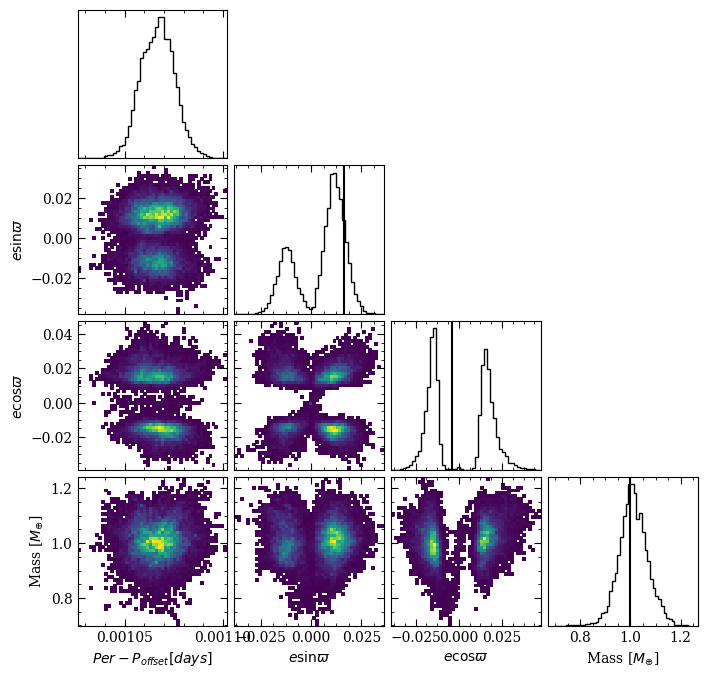

In [201]:
corner_planet(vec(par_mcmc[:,1:nsteps,6]).* CGS.MSUN/CGS.MEARTH,
    (vec(par_mcmc[:,1:nsteps,9]).*sqrt.(vec(par_mcmc[:,1:nsteps,9]).^2 .+ vec(par_mcmc[:,1:nsteps,10]).^2)),
    (vec(par_mcmc[:,1:nsteps,10]).*sqrt.(vec(par_mcmc[:,1:nsteps,9]).^2 .+ vec(par_mcmc[:,1:nsteps,10]).^2)),
    vec(par_mcmc[:,1:nsteps,7]),50,
1,-0.00374,0.016285,365.2564,"earth")

Using original prior on eccentricity.

In [183]:
mu_1,P_1,t01,e1cosw1,e1sinw1,
mu_2,P_2,t02,e2cosw2,e2sinw2,
mu_3,P_3,t03,e3cosw3,e3sinw3,
tmaxsinphi0,tmaxcosphi0,deltaphi = extract_data("OUTPUTS/moon_fitmtry3params.jld2")
@load("mcmc_mtry3results.jld2")

8-element Array{Symbol,1}:
 :par_mcmc    
 :lprob_mcmc  
 :param       
 :nwalkers    
 :nsteps      
 :accept      
 :iburn       
 :indepsamples

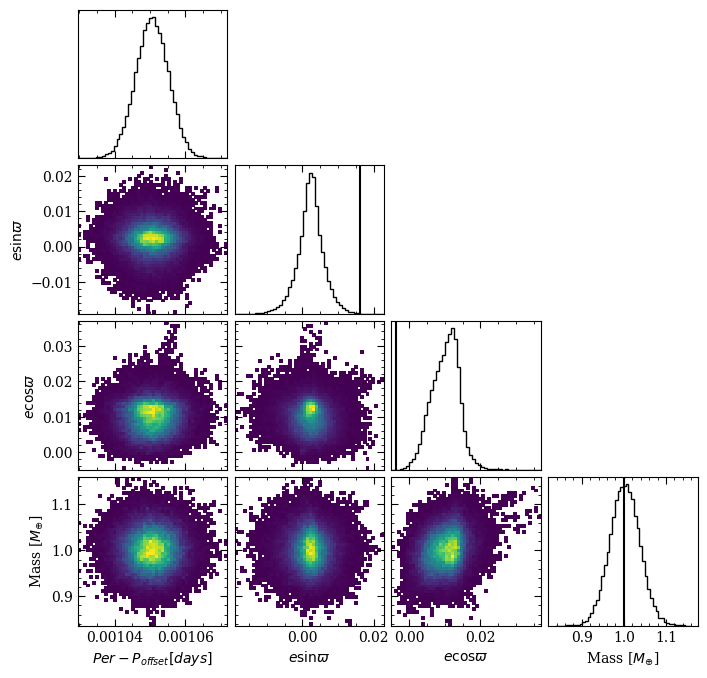

In [190]:
corner_planet(vec(par_mcmc[:,iburn:nsteps,6]).* CGS.MSUN/CGS.MEARTH,
    vec(par_mcmc[:,iburn:nsteps,9]),
    vec(par_mcmc[:,iburn:nsteps,10]),
    vec(par_mcmc[:,iburn:nsteps,7]),50,
1,-0.00374,0.016285,365.2564,"earth")

In [188]:
evec(0.01671022,102.94719)

(-0.0037439728139313944, 0.016285395912195154)

In [186]:
cos(pi)

-1.0